# Custom potential

We solve the 1D Gross-Pitaevskii equation with a custom potential.
This is similar to Gross-Pitaevskii equation in one dimension and we
show how to define local potentials attached to atoms, which allows for
instance to compute forces.

In [1]:
using DFTK
using LinearAlgebra

First, we define a new element which represents a nucleus generating
a Gaussian potential.

In [2]:
struct ElementGaussian <: DFTK.Element
    α  # Prefactor
    L  # Width of the Gaussian nucleus
end

We extend the two methods providing access to the real and Fourier
representation of the potential to DFTK.

In [3]:
function DFTK.local_potential_real(el::ElementGaussian, r::Real)
    -el.α / (√(2π) * el.L) * exp(- (r / el.L)^2 / 2)
end
function DFTK.local_potential_fourier(el::ElementGaussian, q::Real)
    # = ∫ V(r) exp(-ix⋅q) dx
    -el.α * exp(- (q * el.L)^2 / 2)
end

We set up the lattice. For a 1D case we supply two zero lattice vectors

In [4]:
a = 10
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

In this example, we want to generate two Gaussian potentials generated by
two "nuclei" localized at positions ``x_1`` and ``x_2``, that are expressed in
``[0,1)`` in fractional coordinates. ``|x_1 - x_2|`` should be different from
``0.5`` to break symmetry and get nonzero forces.

In [5]:
x1 = 0.2
x2 = 0.8
nucleus = ElementGaussian(1.0, 0.5)
atoms = [nucleus => [[x1, 0, 0], [x2, 0, 0]]];

We setup a Gross-Pitaevskii model

In [6]:
C = 1.0
α = 2;
n_electrons = 1  # Increase this for fun
terms = [Kinetic(),
         AtomicLocal(),
         PowerNonlinearity(C, α),
]
model = Model(lattice; atoms=atoms, n_electrons=n_electrons, terms=terms,
              spin_polarization=:spinless);  # use "spinless electrons"

We discretize using a moderate Ecut and run a SCF algorithm to compute forces
afterwards. As there is no ionic charge associated to `nucleus` we have to specify
a starting density and we choose to start from a zero density.

In [7]:
basis = PlaneWaveBasis(model; Ecut=500, kgrid=(1, 1, 1))
ρ = zeros(eltype(basis), basis.fft_size..., 1)
scfres = self_consistent_field(basis, tol=1e-8, ρ=ρ)
scfres.energies

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   α      Diag
---   ---------------   ---------   --------   ----   ----
  1   -0.143666390587         NaN   3.81e-01   0.80    7.0
  2   -0.156041126848   -1.24e-02   7.91e-02   0.80    1.0
  3   -0.156758349499   -7.17e-04   2.76e-02   0.80    2.0
  4   -0.156952864650   -1.95e-04   1.16e-02   0.80    2.0
  5   -0.156868577803    8.43e-05   1.51e-02   0.80    2.0
  6   -0.157056387779   -1.88e-04   1.95e-04   0.80    1.0
  7   -0.157056406741   -1.90e-08   2.45e-05   0.80    2.0
  8   -0.157056406826   -8.51e-11   1.46e-05   0.80    1.0


Energy breakdown (in Ha):
    Kinetic             0.0380278 
    AtomicLocal         -0.3163434
    PowerNonlinearity   0.1212592 

    total               -0.157056406826

Computing the forces can then be done as usual:

In [8]:
hcat(compute_forces(scfres)...)

2×1 Matrix{StaticArrays.SVector{3, Float64}}:
 [-0.05566136895087902, 0.0, 0.0]
 [0.05565956355464055, 0.0, 0.0]

Extract the converged total local potential

In [9]:
tot_local_pot = DFTK.total_local_potential(scfres.ham)[:, 1, 1]; # use only dimension 1

Extract other quantities before plotting them

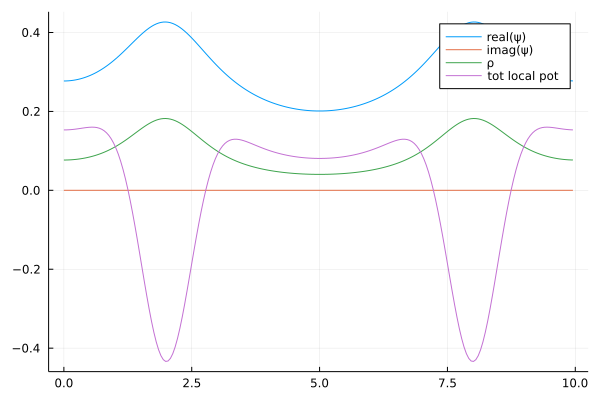

In [10]:
ρ = scfres.ρ[:, 1, 1, 1]  # converged density, first spin component
ψ_fourier = scfres.ψ[1][:, 1];    # first k-point, all G components, first eigenvector
ψ = G_to_r(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));

using Plots
x = a * vec(first.(DFTK.r_vectors(basis)))
p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, imag.(ψ), label="imag(ψ)")
plot!(p, x, ρ, label="ρ")
plot!(p, x, tot_local_pot, label="tot local pot")